In [1]:
import numpy as np
import pandas as pd

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import datasets

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adagrad, RMSprop
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasRegressor

# TensorFlow
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.estimator import LinearClassifier

# Visualisation libraries

## IPython
from IPython.display import clear_output

## Text
from colorama import Fore, Back, Style
from IPython.display import Image, display, Markdown, Latex

## seaborn
import seaborn as sns
sns.set_context('paper', rc={'font.size':12,'axes.titlesize':14,'axes.labelsize':12})
sns.set_style('white')

## matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
import matplotlib.colors
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


<div class="alert alert-block alert-info">
<font size="+3"><b>
Keras Linear Model   
</b></font>
</div>

<img src='https://archive.ics.uci.edu/ml/assets/MLimages/Large14.jpg' height='300' align="center"/>

In this article, we demonstrate implementing the Keras Linear classifier model by an example. The details regarding this dataset can be found in 
[Diagnostic Wisconsin Breast Cancer Database](https://tinyurl.com/gl3yhzb). We would use the following classification methods and then compare them in terms of performance.

## Train and Test sets

In [2]:
Data = datasets.load_breast_cancer(as_frame=True)
Target = 'Diagnosis'
Labels = Data['target_names']
X = Data['data']
y = pd.Series(Data['target']).to_frame(Target)
Data = pd.concat([X,y], axis = 1)
Data.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
display(pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
                           'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T)

Set,X_train,X_test,y_train,y_test
Shape,"(398, 30)","(171, 30)","(398, 1)","(171, 1)"


## Feature Engineering for the Model


A Keras estimator model consists of two main parts, [feature columns](https://www.tensorflow.org/guide/feature_columns), and a numeric vector. Feature columns provide explanations for the input numeric vector. The following function separates Categorical and numerical columns (features)and returns a descriptive list of feature columns.

In [3]:
def Feat_Columns(Inp):
    Temp = Inp.dtypes.reset_index(drop = False)
    Temp.columns = ['Features', 'Data Type']
    Temp['Data Type'] = Temp['Data Type'].astype(str)
    # Numeric_Columns
    Numeric_Columns = Temp.loc[Temp['Data Type'].isin(['int64', 'float64', 'int32', 'float32']),'Features'].tolist()
    # Categorical_Columns
    Categorical_Columns = Temp.loc[Temp['Data Type'] == 'object','Features'].tolist()
        
    # Feature Columns
    feature_columns = []
    if len(Categorical_Columns)>0:
        for feature_name in Categorical_Columns:
          vocabulary = Inp[feature_name].unique()
          feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))
    if len(Numeric_Columns)>0:
        for feature_name in Numeric_Columns:
          feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
    return feature_columns


feature_columns = Feat_Columns(X)
print(Back.GREEN + Fore.BLACK + Style.BRIGHT + 'Feature Columns List:' + Style.RESET_ALL)
display(feature_columns)

Feature Columns List:


[NumericColumn(key='mean radius', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='mean texture', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='mean perimeter', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='mean area', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='mean smoothness', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='mean compactness', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='mean concavity', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='mean concave points', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='mean symmetry', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='mean fracta

The `input_function` specifies how data is converted to a `tf.data.Dataset` that feeds the input pipeline in a streaming fashion. `tf.data.Dataset` can take in multiple sources such as a data frame, a CSV-formatted file, and more.

In [4]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

Train_input_fn = make_input_fn(X_train, y_train)
Evaluation_input_fn = make_input_fn(X_test, y_test, num_epochs=1, shuffle=False)

This can be inspected.

In [5]:
ds = make_input_fn(X_train, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print(Back.CYAN + Fore.BLACK + Style.BRIGHT + 'Some feature keys:' + Style.RESET_ALL, list(feature_batch.keys()))

Some feature keys: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


# Estimator using the default optimizer

In [6]:
estimator = tf.estimator.LinearClassifier(feature_columns=feature_columns)
estimator.train(Train_input_fn)
result = estimator.evaluate(Evaluation_input_fn)
clear_output()
display(pd.DataFrame(result, index = ['']).round(4))

,accuracy,accuracy_baseline,auc,auc_precision_recall,average_loss,label/mean,loss,precision,prediction/mean,recall,global_step
,0.9532,0.6316,0.9579,0.9537,0.455,0.6316,0.4659,0.931,0.681,1.0,130


We can predict the probability for the Test (Evaluation) set.

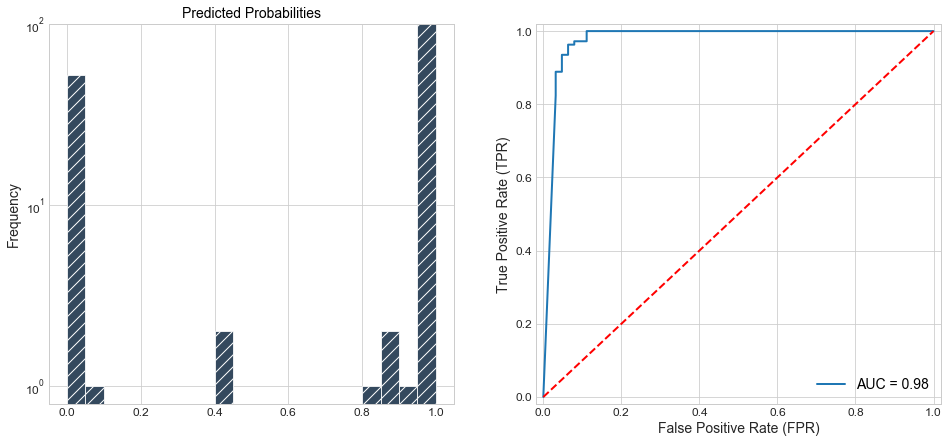

In [7]:
pred_dicts = list(estimator.predict(Evaluation_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
clear_output()

def ROC_Curve(probs, y_test = y_test, pad = 0.05, Title = None, ax = False):
    # false positive rates, true positive rates and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
    if ax == False:
        fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.5))
    _ = ax.plot(fpr, tpr, lw=2, label = 'AUC = %0.2f' % metrics.auc(fpr, tpr))
    _ = ax.plot([0, 1], [0, 1],'r--', lw=2)
    _ = ax.legend(loc = 'lower right', fontsize = 14)
    _ = ax.set_xlim([-pad,1+pad])
    _ = ax.set_ylim([-pad,1+pad])
    _ = ax.set_xlabel('False Positive Rate (FPR)')
    _ = ax.set_ylabel('True Positive Rate (TPR)')
    _ = ax.set_title(Title)
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), sharex=False)
_  = probs.plot(ax = ax[0], kind='hist', bins=20, title='Predicted Probabilities', color='#34495e', hatch="//")
_ = ax[0].set_yscale('log')
_ = ax[0].set_ylim([0, 100])

ROC_Curve(probs, pad = 0.02, ax = ax[1])

# Estimator using the FTRL optimizer with regularization.

[The Follow the Regularized Leader (FTRL)](tf.keras.optimizers.Ftrl) model is an implementation of the FTRL-Proximal online learning algorithm for binomial logistic regression (for details see [6]).


In [8]:
estimator = tf.estimator.LinearClassifier(feature_columns=feature_columns,
                                     optimizer=tf.keras.optimizers.Ftrl(learning_rate=0.1, l1_regularization_strength=0.001))
estimator.train(Train_input_fn)
result = estimator.evaluate(Evaluation_input_fn)
clear_output()
display(pd.DataFrame(result, index = ['']).round(4))

,accuracy,accuracy_baseline,auc,auc_precision_recall,average_loss,label/mean,loss,precision,prediction/mean,recall,global_step
,0.8947,0.6316,0.9331,0.9284,0.5696,0.6316,0.6295,0.8571,0.7384,1.0,130


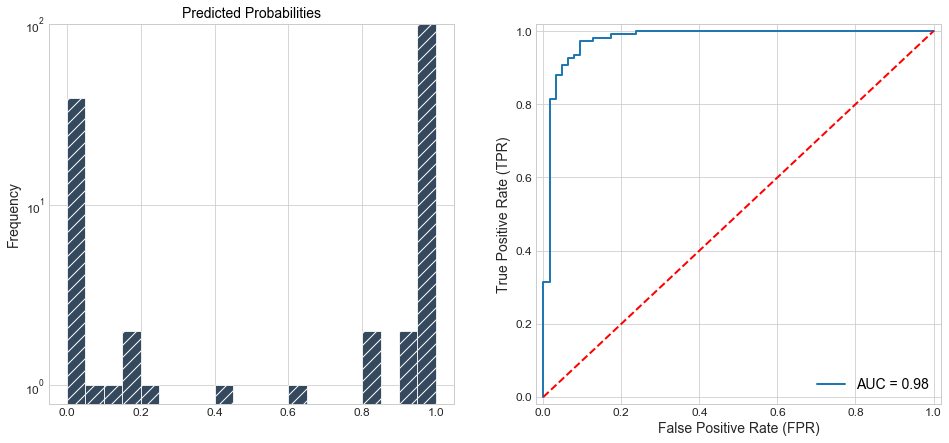

In [9]:
pred_dicts = list(estimator.predict(Evaluation_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
clear_output()

def ROC_Curve(probs, y_test = y_test, pad = 0.05, Title = None, ax = False):
    # false positive rates, true positive rates and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
    if ax == False:
        fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.5))
    _ = ax.plot(fpr, tpr, lw=2, label = 'AUC = %0.2f' % metrics.auc(fpr, tpr))
    _ = ax.plot([0, 1], [0, 1],'r--', lw=2)
    _ = ax.legend(loc = 'lower right', fontsize = 14)
    _ = ax.set_xlim([-pad,1+pad])
    _ = ax.set_ylim([-pad,1+pad])
    _ = ax.set_xlabel('False Positive Rate (FPR)')
    _ = ax.set_ylabel('True Positive Rate (TPR)')
    _ = ax.set_title(Title)
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), sharex=False)
_  = probs.plot(ax = ax[0], kind='hist', bins=20, title='Predicted Probabilities', color='#34495e', hatch="//")
_ = ax[0].set_yscale('log')
_ = ax[0].set_ylim([0, 100])

ROC_Curve(probs, pad = 0.02, ax = ax[1])

# Estimator with warm-starting from a previous checkpoint.

In [10]:
estimator = tf.estimator.LinearClassifier(feature_columns=feature_columns,
                                         warm_start_from='C:\\Users\\hatef\\AppData\\Local\\Temp\\tmpy_sdlxwx')
estimator.train(Train_input_fn)
result = estimator.evaluate(Evaluation_input_fn)
clear_output()
display(pd.DataFrame(result, index = ['']).round(4))

,accuracy,accuracy_baseline,auc,auc_precision_recall,average_loss,label/mean,loss,precision,prediction/mean,recall,global_step
,0.5848,0.6316,0.7546,0.8768,5.0224,0.6316,5.0459,1.0,0.2063,0.3426,130


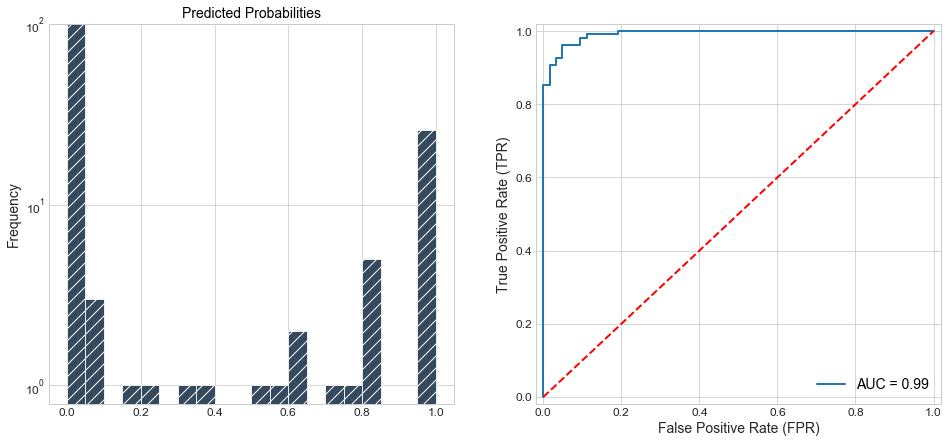

In [11]:
pred_dicts = list(estimator.predict(Evaluation_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
clear_output()

def ROC_Curve(probs, y_test = y_test, pad = 0.05, Title = None, ax = False):
    # false positive rates, true positive rates and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
    if ax == False:
        fig, ax = plt.subplots(1, 1, figsize=(5.5, 5.5))
    _ = ax.plot(fpr, tpr, lw=2, label = 'AUC = %0.2f' % metrics.auc(fpr, tpr))
    _ = ax.plot([0, 1], [0, 1],'r--', lw=2)
    _ = ax.legend(loc = 'lower right', fontsize = 14)
    _ = ax.set_xlim([-pad,1+pad])
    _ = ax.set_ylim([-pad,1+pad])
    _ = ax.set_xlabel('False Positive Rate (FPR)')
    _ = ax.set_ylabel('True Positive Rate (TPR)')
    _ = ax.set_title(Title)
    
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), sharex=False)
_  = probs.plot(ax = ax[0], kind='hist', bins=20, title='Predicted Probabilities', color='#34495e', hatch="//")
_ = ax[0].set_yscale('log')
_ = ax[0].set_ylim([0, 100])

ROC_Curve(probs, pad = 0.02, ax = ax[1])

***
# References

1. Regression analysis. Wikipedia. Last edited on 17 April 2020, at 13:31 (UTC). https://en.wikipedia.org/wiki/Regression_analysis
2. Build a linear model with Estimators, https://www.tensorflow.org/tutorials/estimator/linear
3. W.N. Street, W.H. Wolberg and O.L. Mangasarian. Nuclear feature extraction for breast tumor diagnosis. IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science and Technology, volume 1905, pages 861-870, San Jose, CA, 1993.

4. O.L. Mangasarian, W.N. Street and W.H. Wolberg. Breast cancer diagnosis and prognosis via linear programming. Operations Research, 43(4), pages 570-577, July-August 1995.

5. W.H. Wolberg, W.N. Street, and O.L. Mangasarian. Machine learning techniques to diagnose breast cancer from fine-needle aspirates. Cancer Letters 77 (1994) 163-171.
6. Online machine learning, https://en.wikipedia.org/wiki/Online_machine_learning
7. Learning rate, https://en.wikipedia.org/wiki/Learning_rate
***